# Autoencoders Assignment

Autoencoders are a type of neural networks, trained to reconstruct their own input. Applications range from compression, denoising, reconstruction of images, anomaly detection, image segmentation and recommendation systems.

This assignment consists of 3 parts:

1. Anomaly detection
2. Image denoising
3. Image segmentation


In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score



import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Lambda
from tensorflow.keras.layers import Lambda

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

2024-11-20 10:33:02.998658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 10:33:03.065083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 10:33:03.083122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 10:33:03.193486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 10:33:04.360131: W tensorflow/compiler/tf2

## 1. Fraud detection

An anomaly is a data point that differs significantly (in statistical properties) from the majority of the data points. For example, fraudulent banking transactions can be regarded as anomalies. One of the biggest challenges in detecting anomalies is the imbalancedness of the dataset. These anomalies are by definition rather exceptional.

One possible approach to detecting anomalies is learning the distribution of normal data points, in this case normal banking transactions. New data samples can be classified as anomalies when they are very unlikely according to the learned distribution.

Autoencoders can learn the distribution of the normal data points by learning to reconstruct these normal data points. The trained autoencoder will then struggle to reconstruct anomalies resulting in a high reconstruction error, for example the MSE = Mean Squared Error.
Error. https://keras.io/losses/

𝑀𝑆𝐸=𝑖𝑛∑𝑛𝑖=1(𝑌−𝑌̂ )2

A transaction can therefore be considered fraudulent if the reconstruction error exceeds a certain threshold.
This is referred to as a one-class classifier.


Given is a dataset with bank transactions. Certain features have been anonymized (indicated by V). Other features indicate the amount and time. All transactions were labeled 1 (fraudulent) or 0 (normal transaction).

Go through the following steps:

- Check the imbalancedness of the dataset
- Preprocessing
- Build a training set and test set
- Train the autoencoder
- Use the reconstruction error as a measure of the likelihood that a transactions is fraudulent.
- Evaluate the autoencoder with the test set
- Perform hyperparameter tuning and find an optimal value for the threshold on the reconstruction error.
- Answer the questions


In [2]:
# Reading the dataset
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

### Check for imbalancedness


This is a heavily unbalanced dataset.


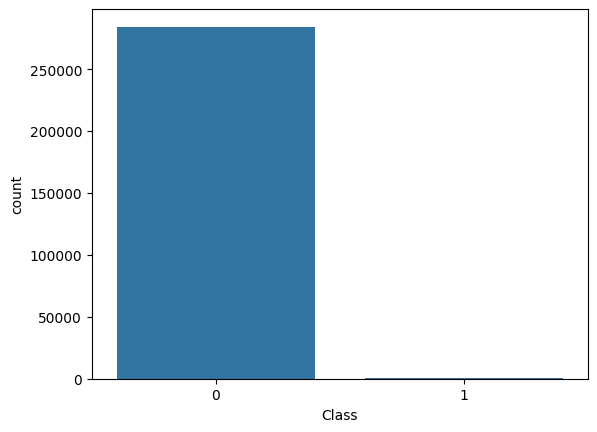

In [3]:
# Check for imbalencedness
sns.countplot(x='Class',data=df)
print("This is a heavily unbalanced dataset.")

In [4]:
df.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

### Preprocessing
- Cleaning if necessary
- Split into training set and test set. The training set only contains normal transactions. The test set contains a balanced mix of both classes.

In [5]:
# Clean the dataset (if necessary)

print(f"There are {len(df.isnull().sum()[df.isnull().sum() > 0])} columns with missing values")
print(f"The values in this dataset are of type - {df.dtypes.unique()}")

There are 0 columns with missing values
The values in this dataset are of type - [dtype('float64') dtype('int64')]


In [6]:
# Split into training set and test set.
# training set should only have non-fraudulent data

import random

normal_data = df[df["Class"] == 0]
fraud_data = df[df["Class"] == 1]

X_normal = normal_data.drop("Class", axis=1).values
y_normal = normal_data["Class"].values

X_train, X_test_normal, y_train, y_test_normal = train_test_split(X_normal, y_normal, test_size=0.2, random_state=0)

X_test_fraud = fraud_data.drop("Class", axis=1).values
y_test_fraud = fraud_data["Class"].values

# combinung normal and fraudulent test data
X_test_combined = list(X_test_normal) + list(X_test_fraud)
y_test_combined = list(y_test_normal) + list(y_test_fraud)


combined_data = list(zip(X_test_combined, y_test_combined))
random.shuffle(combined_data)

X_test, y_test = zip(*combined_data)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(227452, 30) (227452,)
(57355, 30) (57355,)


In [8]:
print(len(np.nonzero(y_train)[0]))
print(len(np.nonzero(y_test)[0]))

0
492


In [7]:
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Training and hyperparameter tuning

- Design and train an autoencoder. Use the MSE (Mean Squared Error) loss function. Choose the size of the neural network yourself. You can adjust this later in the hyperparameter tuning.
- Choose a threshold for the MSE with which you decide whether or not a transaction is fraudulent.
- Use the test set to evaluate the autoencoder. Use the accuracy, confusion matrix, recall, precision, f1-score and the ROC for this.
- Perform hyperparameter tuning to increase performance. Find the optimal MSE threshold. Visualize which points are above the threshold and which are below. Use a different color for the different classes.
- Suppose the bank wants to avoid false negatives (fraudulent transactions classified as normal) as much as possible. What adjustments could you make for that? Try one of them and write down your conclusions.


In [11]:
# Building, testing and optimization of the autoencoder

encoding_dim = 7

input_data = Input(shape=(30,))
encoded = Dense(encoding_dim, activation="relu")(input_data)
decoded = Dense(30, activation="sigmoid")(encoded)
autoencoder = Model(input_data, decoded)


In [12]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
epochs = 50
batchsize = 64

# significant improvement in loss when normalized data is used

autoencoder.fit(X_train, X_train,
                epochs=epochs,
                batch_size=batchsize,
                shuffle=True,
                validation_split = 0.3)

Epoch 1/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0140 - val_loss: 0.0018
Epoch 2/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 956us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 948us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 925us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 12/5

In [13]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


reconstructions = autoencoder.predict(X_test)

# caluculating reconsustruction mse
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)
print(reconstruction_errors)
# calculating thresh using percentile
threshold = np.percentile(reconstruction_errors, 99)

# using mean+3*stdev to define outliers/anomalies
# threshold = np.mean(reconstruction_errors) +  3 * np.std(reconstruction_errors)
print(f"\nThreshold: {threshold}")


y_pred = (reconstruction_errors > threshold).astype(int)  # 1 for fraud, 0 for normal

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, reconstruction_errors)  # Using errors directly for ROC-AUC

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\n",classification_report(y_test, y_pred))
print("Confusion Matrix:\n", conf_matrix)

print(accuracy_score(y_test, y_pred)*100)

   1/1793 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step
[0.00075837 0.00044296 0.00059626 ... 0.00083181 0.00361144 0.00093643]

Threshold: 0.006454878625351828
Precision: 0.6097560975609756
Recall: 0.7113821138211383
F1 Score: 0.6566604127579737
ROC-AUC: 0.959171122891434

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.61      0.71      0.66       492

    accuracy                           0.99     57355
   macro avg       0.80      0.85      0.83     57355
weighted avg       0.99      0.99      0.99     57355

Confusion Matrix:
 [[56639   224]
 [  142   350]]
99.36186906111062


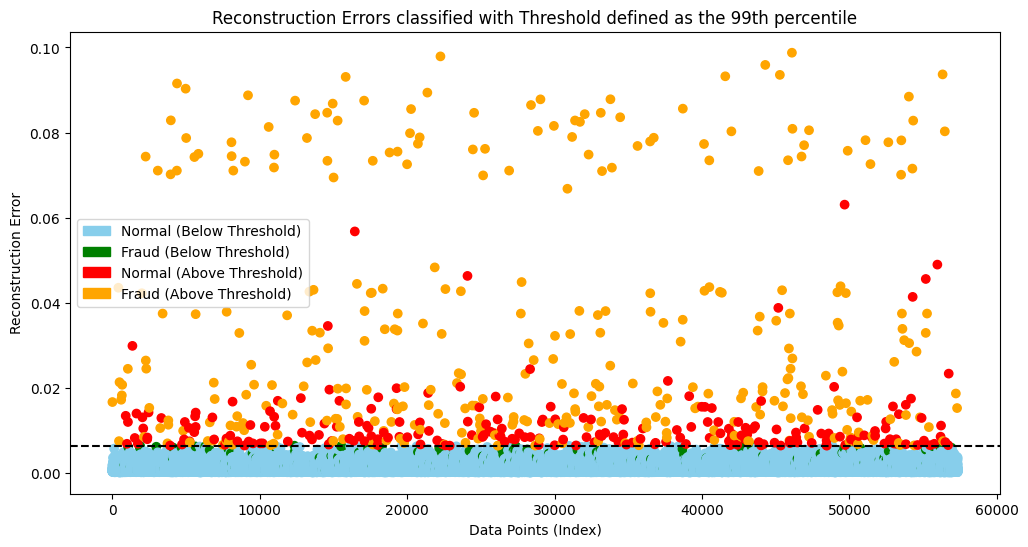

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_thresh(thresh,y_test_array,reconstruction_errors,title):

    plt.figure(figsize=(12, 6))
    above_threshold = reconstruction_errors > thresh # list of bool values
    below_threshold = reconstruction_errors <= thresh

    plt.scatter(
        np.where(below_threshold)[0],
        reconstruction_errors[below_threshold],
        c=['skyblue' if y == 0 else 'green' for y in y_test_array[below_threshold]], # the bool value filters y_test_array to get samples classified as below thresh
        label='Below Threshold'
    )

    plt.scatter(
        np.where(above_threshold)[0],
        reconstruction_errors[above_threshold],
        c=['red' if y == 0 else 'orange' for y in y_test_array[above_threshold]],
        label='Above Threshold'
    )

    plt.axhline(y=thresh, color='black', linestyle='--', label=f"Threshold ({threshold:.2f})")

    # defining legend as green and red values aren't present in the default one
    normal_below = mpatches.Patch(color='skyblue', label='Normal (Below Threshold)')
    fraud_below = mpatches.Patch(color='green', label='Fraud (Below Threshold)')
    normal_above = mpatches.Patch(color='red', label='Normal (Above Threshold)')
    fraud_above = mpatches.Patch(color='orange', label='Fraud (Above Threshold)')

    plt.legend(handles=[normal_below, fraud_below, normal_above, fraud_above])
    plt.title(title)
    plt.xlabel("Data Points (Index)")
    plt.ylabel("Reconstruction Error")
    plt.show()

threshold = np.percentile(reconstruction_errors, 99)
plot_thresh(threshold,
            y_test,
            reconstruction_errors,
            "Reconstruction Errors classified with Threshold defined as the 99th percentile")


In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay

reconstructions = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)

def min_fnr_threshold(reconstruction_errors, y_test, tpr_range):
    fpr, tpr, roc_thresholds = roc_curve(y_test, reconstruction_errors)

    # maximizing tpr(recall) as fnr=1-recall

    desired_tpr = tpr_range # min tpr
    print("\nMinimizing False Negatives by Maximizing FPR (Recall) -\n")

    for i in desired_tpr:
        best_threshold = roc_thresholds[np.where(tpr >= i)[0][0]]

        # Evaluate at the optimal threshold
        y_pred_optimal = (reconstruction_errors > best_threshold).astype(int)
        precision = precision_score(y_test, y_pred_optimal)
        recall = recall_score(y_test, y_pred_optimal)
        f1 = f1_score(y_test, y_pred_optimal)
        roc_auc = roc_auc_score(y_test, reconstruction_errors)

        # Output the results
        print("Optimal Threshold:", best_threshold)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("ROC-AUC:", roc_auc)
        print(f"Desired TPR: {i}")

        # Confusion Matrix and Classification Report
        conf_matrix = confusion_matrix(y_test, y_pred_optimal)
        print("\nClassification Report:\n", classification_report(y_test, y_pred_optimal))
        print("Confusion Matrix:\n", conf_matrix)

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred_optimal)
        print("Accuracy:", accuracy * 100,"\n\n")


min_fnr_threshold(reconstruction_errors=reconstruction_errors,
                  y_test=y_test,
                  tpr_range=np.linspace(0.8,0.91,5) )



   1/1793 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step

Minimizing False Negatives by Maximizing FPR (Recall) -

Optimal Threshold: 0.004936587519822921
Precision: 0.4937185929648241
Recall: 0.7987804878048781
F1 Score: 0.610248447204969
ROC-AUC: 0.959171122891434
Desired TPR: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.49      0.80      0.61       492

    accuracy                           0.99     57355
   macro avg       0.75      0.90      0.80     57355
weighted avg       0.99      0.99      0.99     57355

Confusion Matrix:
 [[56460   403]
 [   99   393]]
Accuracy: 99.1247493679714 


Optimal Threshold: 0.003977399999809513
Precision: 0.35299219427580225
Recall: 0.8272357723577236
F1 Score: 0.4948328267477204
ROC-AUC: 0.959171122891434
Desired TPR: 0.8275

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.9

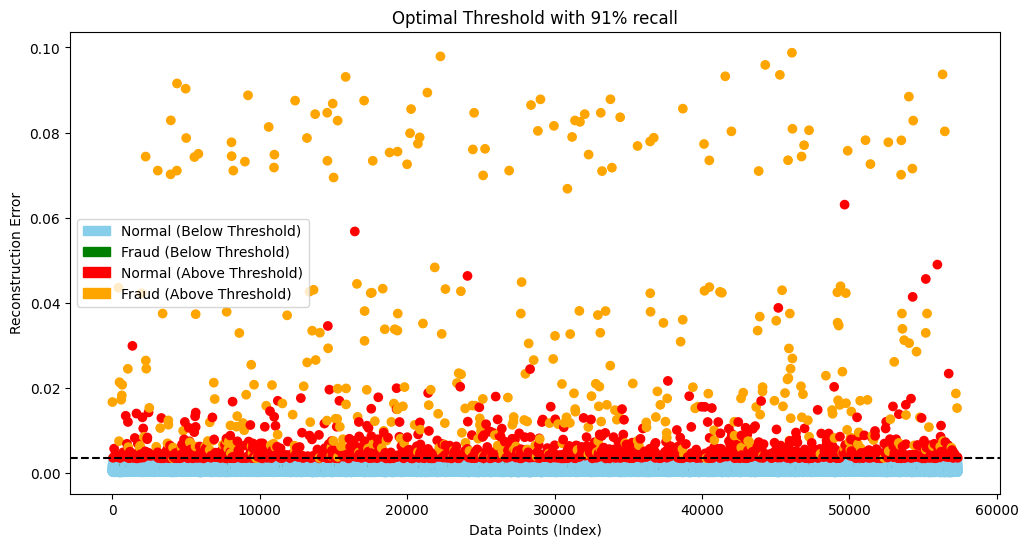

I tried to minimize the false negative rate by maximizing recall as FNR = 1-recall.
I found that the FNR cannnot be minimized without a significant loss in precision.
The graph above plots the classification by a threshold that has a recall of 0.84 for the fradulent class and 0.99 for the normal class.


In [24]:
plot_thresh(0.0034731261851645616,
            y_test,
            reconstruction_errors,
            "Optimal Threshold with 91% recall")


print("I tried to minimize the false negative rate by maximizing recall as FNR = 1-recall.\nI found that the FNR cannnot be minimized without a significant loss in precision.")
print("The graph above plots the classification by a threshold that has a recall of 0.84 for the fradulent class and 0.99 for the normal class.")

In [ ]:
param_grid = {
    'encoding_dims': [5, 7, 10],
    'batch_sizes': [32, 64, 128],
    'activation_funcs': ["leaky_relu","relu","elu"]
}
best_recall = 0

for encoding_dim in param_grid['encoding_dims']:
  for batchsize in param_grid['batch_sizes']:
    for activation_func in param_grid['activation_funcs']:

        input_data = Input(shape=(30,))
        encoded = Dense(encoding_dim, activation=activation_func)(input_data)
        decoded = Dense(30, activation="sigmoid")(encoded)
        autoencoder = Model(input_data, decoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')

        epochs = 50
        batchsize = 64


        autoencoder.fit(X_train, X_train,
                        epochs=epochs,
                        batch_size=batchsize,
                        shuffle=True,
                        validation_split = 0.3,
                        verbose = 1)

        reconstructions = autoencoder.predict(X_test)

        reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)
        threshold = np.percentile(reconstruction_errors, 99.2)
        y_pred = (reconstruction_errors > threshold).astype(int)
        recall = recall_score(y_test, y_pred)

        if recall>best_recall:
            best_recall=recall
            best_parameters = [encoding_dim,batchsize,activation_func]

Epoch 1/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0128 - val_loss: 0.0019
Epoch 2/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/50
2488/2488 ━━━━━━━━

KeyboardInterrupt: 

#### Overcomplete Autoencoders

In [26]:
encoding_dim = 45

input_data = Input(shape=(30,))
# L1 regularization
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(input_data)
decoded = Dense(30, activation='sigmoid')(encoded)

overcomplete_autoencoder = Model(input_data, decoded)


encoded_input = Input(shape=(encoding_dim,))
# Get the last layer
decoder_layer = overcomplete_autoencoder.layers[-1]
# create the overcomplete_autoencoder model
# Create a seperte encoder model
encoder = Model(input_data, encoded)
decoder = Model(encoded_input, decoder_layer(encoded_input))


# Compilation
overcomplete_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ["accuracy"])

In [27]:
epochs = 50
batchsize = 64

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
]

overcomplete_autoencoder.fit(X_train, X_train,
                epochs=epochs,
                batch_size=batchsize,
                shuffle=True,
                validation_split=0.3)

Epoch 1/50


2488/2488 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8432 - loss: 0.0051 - val_accuracy: 0.9539 - val_loss: 7.4170e-04
Epoch 2/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9525 - loss: 6.3486e-04 - val_accuracy: 0.9540 - val_loss: 4.5605e-04
Epoch 3/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9540 - loss: 4.1737e-04 - val_accuracy: 0.9541 - val_loss: 3.3534e-04
Epoch 4/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9535 - loss: 3.1134e-04 - val_accuracy: 0.9544 - val_loss: 2.6753e-04
Epoch 5/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - accuracy: 0.9552 - loss: 2.5508e-04 - val_accuracy: 0.9603 - val_loss: 2.2139e-04
Epoch 6/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9625 - loss: 2.0613e-04 - val_accuracy: 0.9681 - val_loss: 1.8556e-04
Epoch 7/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9695 - loss: 1.7731e-04 - val_accuracy: 0.9732 - val_loss: 1.6248e-04
Epoch 8/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 3s 1m

   1/1793 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step
[1.00721550e-05 9.54190627e-06 6.67514472e-06 ... 8.36968857e-06
 3.87248567e-05 4.66814069e-06]

Threshold: 0.00013232295886228518
Precision: 0.3501742160278746
Recall: 0.8170731707317073
F1 Score: 0.4902439024390244
ROC-AUC: 0.939049947320253

               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.35      0.82      0.49       492

    accuracy                           0.99     57355
   macro avg       0.67      0.90      0.74     57355
weighted avg       0.99      0.99      0.99     57355

Confusion Matrix:
 [[56117   746]
 [   90   402]]
98.54241129805597


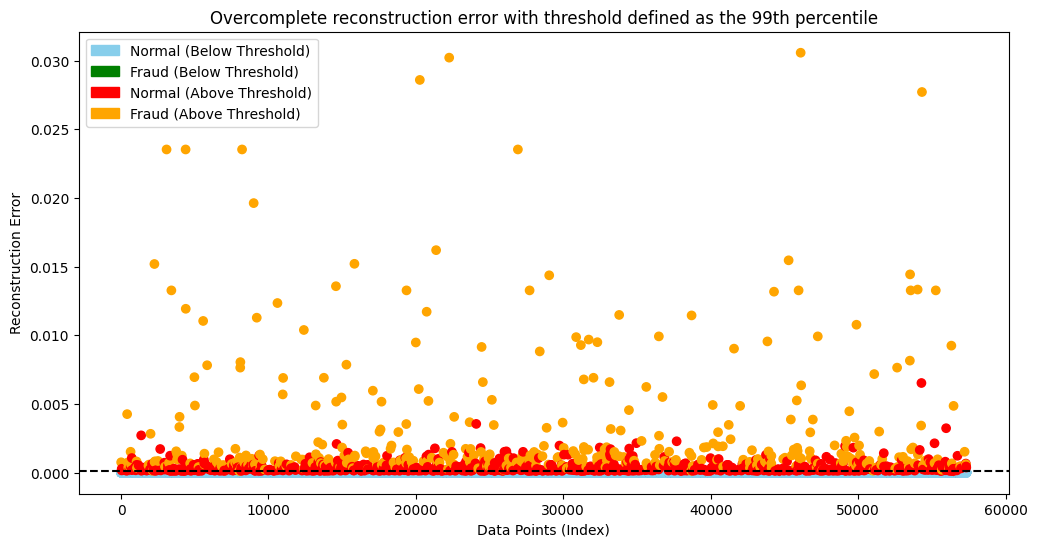

In [28]:
reconstructions = overcomplete_autoencoder.predict(X_test)

# caluculating reconsustruction mse
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)
print(reconstruction_errors)
# calculating thresh using percentile
threshold = np.percentile(reconstruction_errors, 98)

# using mean+3*stdev to define outliers
# threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
print(f"\nThreshold: {threshold}")


y_pred = (reconstruction_errors > threshold).astype(int)  # 1 for fraud, 0 for normal

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, reconstruction_errors)  # Using errors directly for ROC-AUC

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\n",classification_report(y_test, y_pred))
print("Confusion Matrix:\n", conf_matrix)

print(accuracy_score(y_test, y_pred)*100)

plot_thresh(threshold,
            y_test,
            reconstruction_errors,
            "Overcomplete reconstruction error with threshold defined as the 99th percentile")

In [54]:
reconstructions = overcomplete_autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)

min_fnr_threshold(reconstruction_errors=reconstruction_errors,
                  y_test=y_test,
                  tpr_range=np.linspace(0.8,0.91,5) )


1793/1793 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Minimizing False Negatives by Maximizing FPR (Recall) -

Optimal Threshold: 0.00030815145998426763
Precision: 0.7171532846715328
Recall: 0.7987804878048781
F1 Score: 0.7557692307692307
ROC-AUC: 0.9371948967629944
Desired TPR: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.72      0.80      0.76       492

    accuracy                           1.00     57355
   macro avg       0.86      0.90      0.88     57355
weighted avg       1.00      1.00      1.00     57355

Confusion Matrix:
 [[56708   155]
 [   99   393]]
Accuracy: 99.5571441025194 


Optimal Threshold: 0.00011604860103460216
Precision: 0.35299219427580225
Recall: 0.8272357723577236
F1 Score: 0.4948328267477204
ROC-AUC: 0.9371948967629944
Desired TPR: 0.8275

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99    

### Answer the following questions
- Which type of autoencoder is most suitable (undercomplete, overcomplete, convolutional, ...)? Why?
- Would it make sense to use the categorical cross-entropy as a loss function?
- Plot a histogram of the MSE values (on the training set). How are these distributed? Can you estimate the optimal threshold from this histogram?


1.
I think that undercomplete autoencoders are better suited for fraud detection.
Convolutional autoencoders are not suited for this task as we are not dealing with sequential or time series data.
The overcomplete autoencoder has a much lower reconstruction error range compared to the undercomplete autencoder ([0.0 -> 0.03] vs [0.0 -> 0.2])
Thus the reconstruction error for fradulent transactions is also much closer to the ones for normal transactions.
In the case of undercomplete autoencoders, there is a more visible difference and errors for the fraudulent samples are much higher and spread out.

This suggests that the overcomplete autoencoder is having some trouble in meaningfully distinguishing fraduent and non-fraudulent transactions.
This is more apparent when looking for the optimal threshold as any minute change impacts the recall a lot more as all of the errors are much closer to each other.
-------

2.
It doesn't make much sense to use categorical loss entropy as a function a

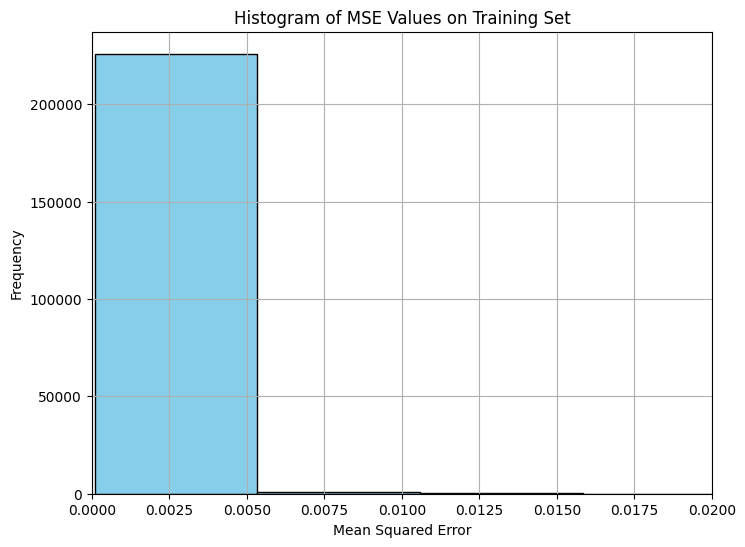

Estimated threshold (99th percentile): 0.006172081328978959


In [30]:
print("1.")
print("I think that undercomplete autoencoders are better suited for fraud detection.")
print("Convolutional autoencoders are not suited for this task as we are not dealing with sequential or time series data.")
print("The overcomplete autoencoder has a much lower reconstruction error range compared to the undercomplete autencoder ([0.0 -> 0.03] vs [0.0 -> 0.2])")
print("Thus the reconstruction error for fradulent transactions is also much closer to the ones for normal transactions.")
print("In the case of undercomplete autoencoders, there is a more visible difference and errors for the fraudulent samples are much higher and spread out.")
print("\nThis suggests that the overcomplete autoencoder is having some trouble in meaningfully distinguishing fraduent and non-fraudulent transactions.\nThis is more apparent when looking for the optimal threshold as any minute change impacts the recall a lot more as all of the errors are much closer to each other.")
print("-------")
print("\n2.")
print("It doesn't make much sense to use categorical loss entropy as a function as the training data is not classified into discrete classes.\nInstead, the model needs to output a continuous reconstruction error.")
print("Loss functions like Mean Squared Error and Mean Absolute Error aare better suited to this task.")
print("-------")
print("\n3.")
print("Not quite. While it is true that we can find the threshold to perfectly seperate the non-fradulent data, this doesn't account for the fradulent data that is harder to classify.")
print("This threshold is good but not optimal when we want to minimize FNR.")
# Get the reconstruction of the training data
reconstructions_train = autoencoder.predict(X_train)

# Calculate MSE for each sample in the training set
mse_train = np.mean(np.square(X_train - reconstructions_train), axis=1)

# Plot a histogram of the MSE values
plt.figure(figsize=(8, 6))
plt.hist(mse_train, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of MSE Values on Training Set')
plt.xlabel('Mean Squared Error')
plt.xlim([0,0.02])
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

threshold = np.percentile(mse_train, 99.5)
print(f"Estimated threshold (99th percentile): {threshold}")



1793/1793 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step


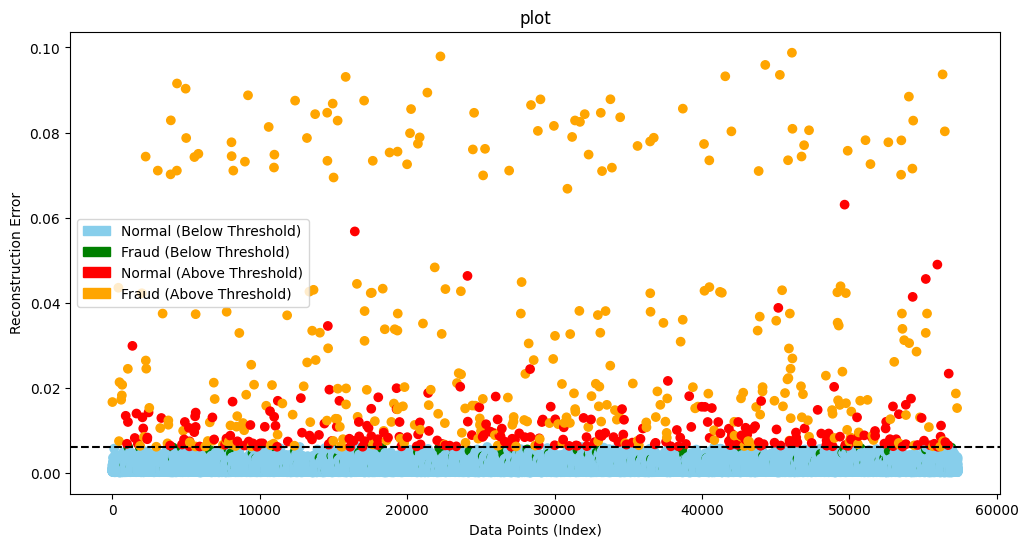

Precision: 0.5967213114754099
Recall: 0.7398373983739838
F1 Score: 0.6606170598911071
ROC-AUC: 0.959171122891434

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.60      0.74      0.66       492

    accuracy                           0.99     57355
   macro avg       0.80      0.87      0.83     57355
weighted avg       0.99      0.99      0.99     57355

Confusion Matrix:
 [[56617   246]
 [  128   364]]


In [31]:
reconstructions = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)
plot_thresh(threshold,y_test,reconstruction_errors,"plot")


y_pred = (reconstruction_errors > threshold).astype(int)  # 1 for fraud, 0 for normal

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, reconstruction_errors)  # Using errors directly for ROC-AUC

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\n",classification_report(y_test, y_pred))
print("Confusion Matrix:\n", conf_matrix)


## Reconstruction of partially occluded faces

Partially occluded faces are faces that are partially covered, for example by glasses, a scarf, etc.
Using an autoencoder, we'll try to reconstruct the covered area.
To achieve this, we need to have a training set that consists of both occluded and clear images of the same face.
We will generate this training set ourselves, starting from an existing face dataset that can be found in the folder 'Faces'. Occluding the face is done by randomly placing an artificial white square on the face. An example can be found below:
![Partially occluded face](./NotebookImages/occlusion_example.png)

Make sure that the training set is contains a sufficient amount of examples. You can use the same image multiple times to create new occluded versions. 

- Try different types of autoencoders (convolutional, undercomplete, overcomplete, ...). Also, vary the number and size of the (code) layer(s).
- If needed downsize the dimensions of the images
- Try different loss functions.
- Write down your findings with each of these different models


In [2]:
import cv2, os, random

input_folder = 'Faces'

clear_images = []
occluded_images = []

def apply_random_occlusion(image, square_size=30):

    height, width = image.shape[:2]
    # making sure the squares are mostly on the faces and not at the edges
    max_x = width - square_size - 20
    max_y = height - square_size - 20

    x_start = random.randint(20, max_x)
    y_start = random.randint(20, max_y)

    # plotting
    image[y_start:y_start + square_size, x_start:x_start + square_size] = 255
    return image

for i in range(6):
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_folder, filename)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (128,128))

            clear_images.append(image)

            occluded_image = apply_random_occlusion(image.copy())

            occluded_images.append(occluded_image)


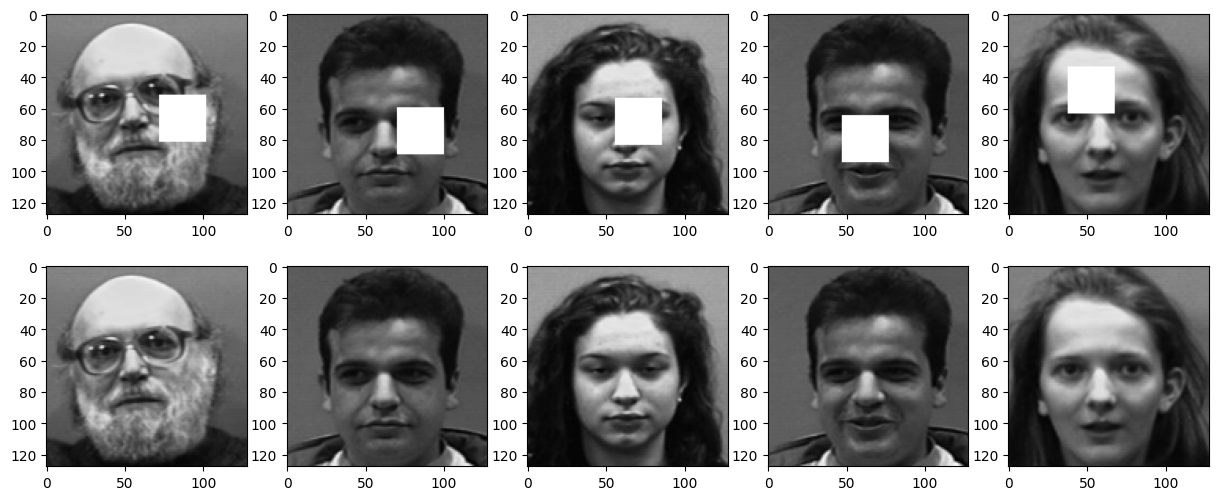

In [3]:
f,ax = plt.subplots(2,5, figsize=(15,6))
for i in range(5,10):
  ax[0,i-5].imshow(occluded_images[i])
for i in range(5,10):
  ax[1,i-5].imshow(clear_images[i])

In [4]:
data = list(zip(occluded_images, clear_images))
random.shuffle(data)
X, Y = zip(*data)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


X_train = np.array(X_train).astype(np.float32)/255.0
y_train = np.array(y_train).astype(np.float32)/255.0
X_test = np.array(X_test).astype(np.float32)/255.0
y_test = np.array(y_test).astype(np.float32)/255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(950, 128, 128, 3) (950, 128, 128, 3)
(238, 128, 128, 3) (238, 128, 128, 3)


In [27]:
occluded_image.shape

(128, 128, 3)

In [8]:
occluded_images_flat = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).flatten() for img in occluded_images])
clear_images_flat = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).flatten() for img in clear_images])

data = list(zip(occluded_images_flat, clear_images_flat))
random.shuffle(data)
X_flat, Y_flat = zip(*data)

X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(X_flat, Y_flat, test_size=0.2, random_state=0)


X_train_flat = np.array(X_train_flat).astype(np.float32)/255.0
y_train_flat = np.array(y_train_flat).astype(np.float32)/255.0
X_test_flat = np.array(X_test_flat).astype(np.float32)/255.0
y_test_flat = np.array(y_test_flat).astype(np.float32)/255.0

print(X_train_flat.shape, y_train_flat.shape)
print(X_test_flat.shape, y_test_flat.shape)


(950, 16384) (950, 16384)
(238, 16384) (238, 16384)


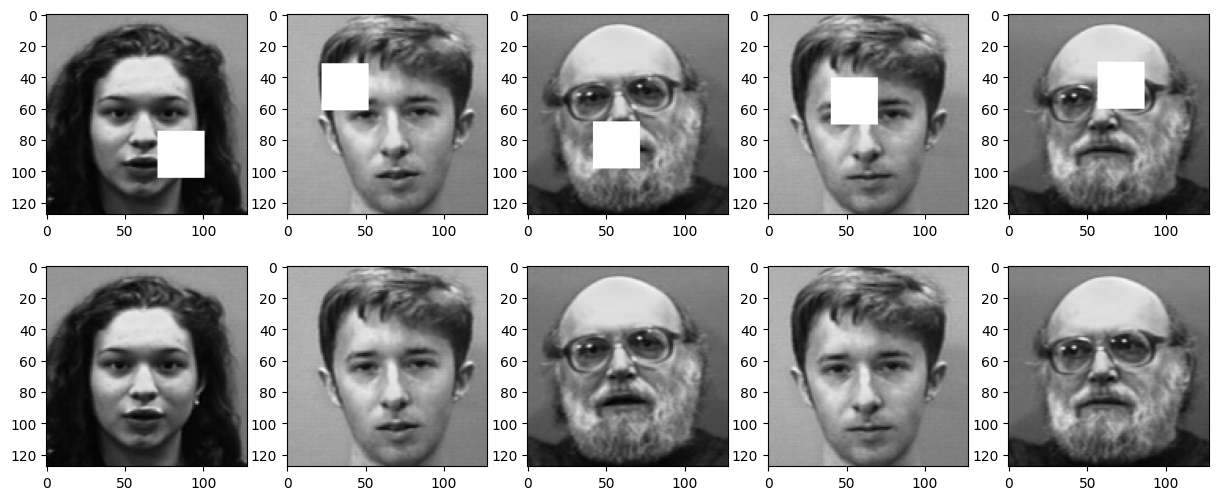

In [9]:
f,ax = plt.subplots(2,5,figsize=(15,6))
for i in range(5,10):
  img = X_test_flat[i] # type float32
  restored_image = img.flatten().reshape((128, 128))
  restored_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_GRAY2RGB)
  ax[0,i-5].imshow(restored_image_rgb)
for i in range(5,10):
  img = y_test_flat[i].astype(np.float32) # there are issues with plotting when the type is float64
  img = (img).flatten().reshape((128, 128))
  img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  ax[1,i-5].imshow(img_rgb)


In [48]:
X_test_flat[1].shape

(16384,)

#### Undercomplete autoencoders (Dense simple, Dense deep and Conv simple)

In [15]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

def calculate_mse(original, reconstructed):
    # MSE is calculated by comparing the original and the reconstructed images
    return mean_squared_error(original.flatten(), reconstructed.flatten())

def calculate_psnr(original, reconstructed):
    # PSNR calculation
    mse_value = calculate_mse(original, reconstructed)
    if mse_value == 0:
        return 100  # PSNR is infinite if there is no error
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse_value))
    return psnr_value

def calculate_ssim(original, reconstructed,color=False):
    # Ensure win_size is odd and smaller than or equal to the image dimensions
    min_dimension = min(original.shape[:2])  # Get the smaller of height or width
    win_size = min(7, min_dimension)  # Set win_size to the smaller dimension, and ensure it's <= 7
    if color:
        return ssim(original, reconstructed, multichannel=True, win_size=win_size, channel_axis=2, data_range=1.0)
    else:
        return ssim(original, reconstructed, multichannel=False, win_size=win_size, data_range=1.0)


Basic Undercomplete Autoencoder

In [62]:
# training a basic undercomplete autoencoder

input_dim = 128*128

encoder_input = Input(shape=(input_dim,))

encoded = Dense(64, activation='elu')(encoder_input)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(encoder_input, decoded)



In [63]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
epochs = 130
batchsize = 16


autoencoder.fit(X_train_flat, y_train_flat,
                epochs=epochs,
                batch_size=batchsize,
                shuffle=True,
                validation_split = 0.1)

Epoch 1/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0443 - val_loss: 0.0184
Epoch 2/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0158 - val_loss: 0.0103
Epoch 3/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 4/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 5/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 6/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 7/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 8/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 9/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 10/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 11/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 12/130
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

In [64]:

# Example: Evaluate reconstruction for all images in the test set
mse_scores = []
psnr_scores = []
ssim_scores = []

# Assume clear_images and occluded_images are your dataset of clear and occluded images
reconstructed_images = autoencoder.predict(X_test_flat)
for pred_img, real_img in zip(reconstructed_images, y_test_flat):
    mse = calculate_mse(real_img, pred_img)
    psnr = calculate_psnr(real_img, pred_img)
    ssim_value = calculate_ssim(real_img, pred_img)

    mse_scores.append(mse)
    psnr_scores.append(psnr)
    ssim_scores.append(ssim_value)

# Calculate average scores
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average PSNR: {np.mean(psnr_scores)}")
print(f"Average SSIM: {np.mean(ssim_scores)}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Average MSE: 0.002706974046304822
Average PSNR: 74.64317135162742
Average SSIM: 0.8010839743564946


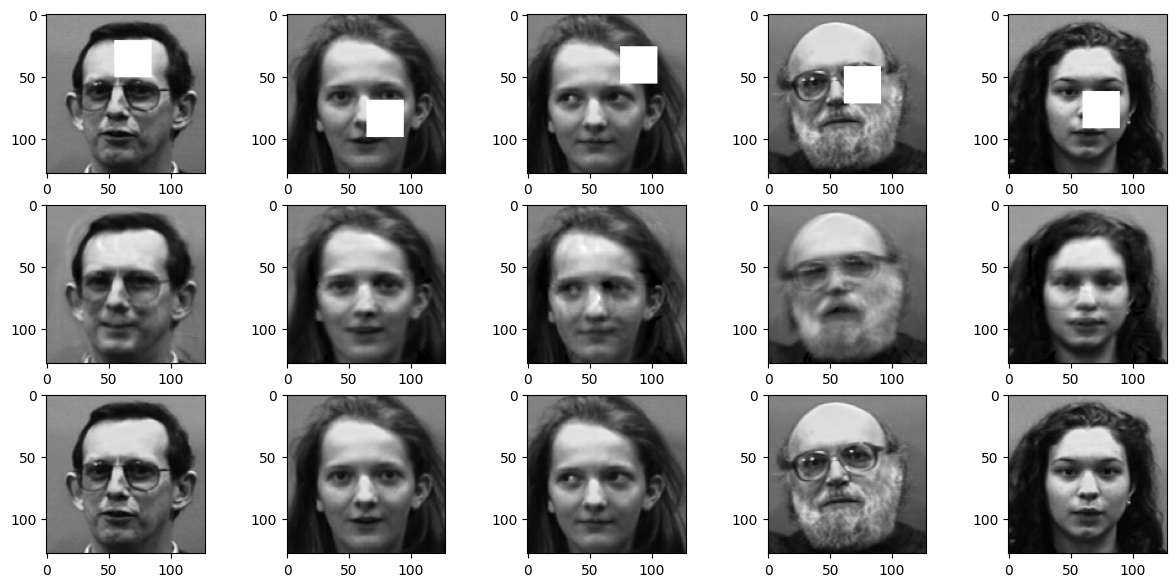

In [65]:
f,ax = plt.subplots(3,5,figsize=(15,7))
for i in range(5,10):
  img = X_test_flat[i] # type float32
  restored_image = img.flatten().reshape((128, 128))
  restored_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_GRAY2RGB)
  ax[0,i-5].imshow(restored_image_rgb)
for i in range(5,10):
  img = reconstructed_images[i] # type float32
  restored_image = img.flatten().reshape((128, 128))
  restored_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_GRAY2RGB)
  ax[1,i-5].imshow(restored_image_rgb)
for i in range(5,10):
  img = y_test_flat[i].astype(np.float32) # there are issues with plotting when the type is float64
  img = (img).flatten().reshape((128, 128))
  img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  ax[2,i-5].imshow(img_rgb)


In [45]:
print("- The first reconstructed image in the graph adds features from other images of the same person (noticable in the mouth area).")
print("- This suggests that the model might be overfitting.")
print("- The reconstructions are very blurry and the effect is similar to that of overlapping different principal components in PCA.")
print("- Overall, this model's performance is decent with room for improvement and isn't computationally intensive.")

- The first reconstructed image in the graph adds features from other images of the same person (noticable in the mouth area).
- This suggests that the model might be overfitting.
- The reconstructions are very blurry and the effect is similar to that of overlapping different principal components in PCA.
- Overall, this model's performance is decent with room for improvement and isn't computationally intensive.


Deep Undercomplete Autoencoder

In [13]:

input_dim = 128 * 128

# Encoder
encoder_input = Input(shape=(input_dim,))
x = Dense(512, activation='relu')(encoder_input)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
encoded = Dense(32, activation='relu')(x)

# Decoder
x = Dense(128, activation='relu')(encoded)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)

decoded = Dense(input_dim, activation='sigmoid')(x)

# Autoencoder Model
autoencoder = Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])



In [19]:
epochs = 100
batchsize = 16

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
]

autoencoder.fit(X_train_flat, y_train_flat,
                epochs=epochs,
                batch_size=batchsize,
                shuffle=True,
                validation_split = 0.1,
                callbacks=callbacks)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1045 - loss: 0.0015 - val_accuracy: 0.1368 - val_loss: 0.0014 - learning_rate: 6.2500e-05
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1274 - loss: 0.0015 - val_accuracy: 0.1368 - val_loss: 0.0014 - learning_rate: 6.2500e-05
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1149 - loss: 0.0016 - val_accuracy: 0.1158 - val_loss: 0.0014 - learning_rate: 6.2500e-05
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1219 - loss: 0.0016 - val_accuracy: 0.1474 - val_loss: 0.0014 - learning_rate: 6.2500e-05
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1455 - loss: 0.0015 - val_accuracy: 0.1474 - val_loss: 0.0014 - learning_rate: 6.2500e-05
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1107 - loss: 0.0015 - val_accuracy: 0.1368 - val_loss: 0.0014 - learning_rate: 6.2500e-05
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 

In [20]:
mse_scores = []
psnr_scores = []
ssim_scores = []

# Assume clear_images and occluded_images are your dataset of clear and occluded images
reconstructed_images = autoencoder.predict(X_test_flat)
for pred_img, real_img in zip(reconstructed_images, y_test_flat):
  mse = calculate_mse(real_img, pred_img)
  psnr = calculate_psnr(real_img, pred_img)
  # ssim_value = calculate_ssim(real_img, pred_img)

  mse_scores.append(mse)
  psnr_scores.append(psnr)
  # ssim_scores.append(ssim_value)

# Calculate average scores
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average PSNR: {np.mean(psnr_scores)}")
# print(f"Average SSIM: {np.mean(ssim_scores)}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Average MSE: 0.0012702111853286624
Average PSNR: 78.09723583880755


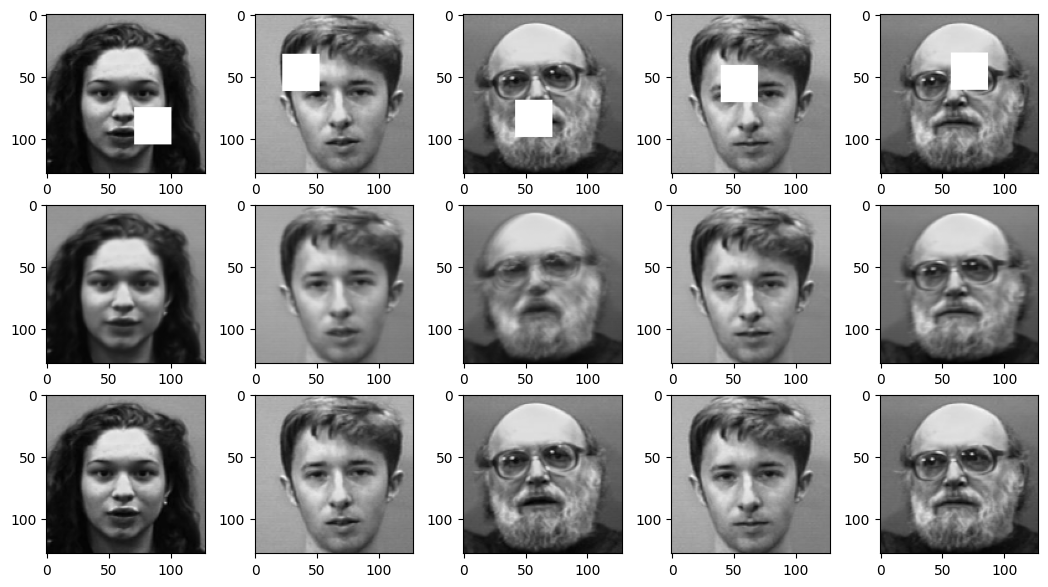

In [21]:
f,ax = plt.subplots(3,5,figsize=(13,7))
for i in range(5,10):
  img = X_test_flat[i] # type float32
  restored_image = img.flatten().reshape((128, 128))
  restored_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_GRAY2RGB)
  ax[0,i-5].imshow(restored_image_rgb)
for i in range(5,10):
  img = reconstructed_images[i] # type float32
  restored_image = img.flatten().reshape((128, 128))
  restored_image_rgb = cv2.cvtColor(restored_image, cv2.COLOR_GRAY2RGB)
  ax[1,i-5].imshow(restored_image_rgb)
for i in range(5,10):
  img = y_test_flat[i].astype(np.float32) # there are issues with plotting when the type is float64
  img = (img).flatten().reshape((128, 128))
  img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  ax[2,i-5].imshow(img_rgb)


In [42]:
print("""
- The dense undercomplete autoencoder is by far the best performing model.
- It is more computationally intensive compared to the simple undercomplete autoencoder.
- The reconstructions are fitting and clear.
""")



- The dense undercomplete autoencoder is by far the best performing model.
- It is more computationally intensive compared to the simple undercomplete autoencoder.
- The reconstructions are fitting and clear.



Convolutional Undercomplete Autoencoder

In [28]:


# Encoder
input_img = Input(shape=(128, 128, 3))
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoder = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Model
autoencoder = Model(input_img, decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [29]:
# autoencoder.compile(optimizer='adam', loss='mean_squared_error')
epochs = 130
batchsize = 20


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val{loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
]

autoencoder.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batchsize,
                shuffle=True,
                validation_split = 0.1,
                callbacks=callbacks)

Epoch 1/130
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 550ms/step - loss: 0.0447 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 2/130
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0135 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 3/130
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0085 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 4/130
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0062 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 5/130
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0051 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 6/130
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0047 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 7/130
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0045 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 8/130
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0043 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 9/130
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0039 - val_loss: 0.0037 - learning_rate: 0.0010


In [30]:

mse_scores = []
psnr_scores = []
ssim_scores = []

# Assume clear_images and occluded_images are your dataset of clear and occluded images
reconstructed_images = autoencoder.predict(X_test)
for pred_img, real_img in zip(reconstructed_images, y_test):
  mse = calculate_mse(real_img, pred_img)
  psnr = calculate_psnr(real_img, pred_img)
  ssim_value = calculate_ssim(real_img, pred_img, True)

  mse_scores.append(mse)
  psnr_scores.append(psnr)
  ssim_scores.append(ssim_value)

# Calculate average scores
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average PSNR: {np.mean(psnr_scores)}")
print(f"Average SSIM: {np.mean(ssim_scores)}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 429ms/step
Average MSE: 0.002265548100695014
Average PSNR: 74.96844319587201
Average SSIM: 0.8372719883918762


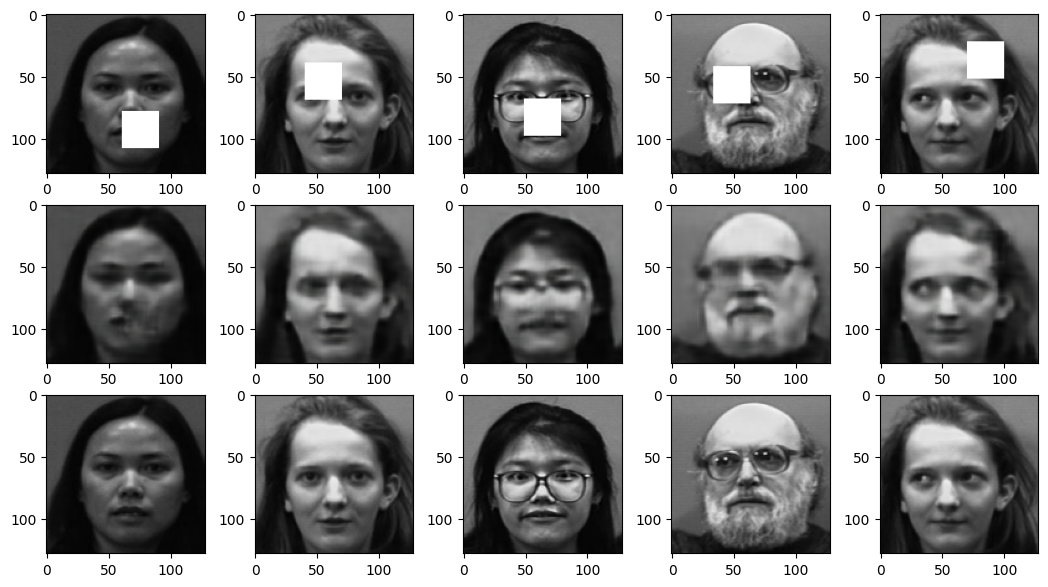

In [31]:
f,ax = plt.subplots(3,5,figsize=(13,7))
for i in range(5,10):
  img = X_test[i] # type float32
  ax[0,i-5].imshow(img)
for i in range(5,10):
  img = reconstructed_images[i] # type float32
  ax[1,i-5].imshow(img)
for i in range(5,10):
  img = y_test[i].astype(np.float32) # there are issues with plotting when the type is float64
  ax[2,i-5].imshow(img)


In [46]:
print("""
- This model needs a lot of memory and was slow to train.
- The reconstructions of the occluded parts are quite noticable and very pixelated.
- It has trouble identifying defining features compared to the undercomplete autoencoders made of dense layers.
""")


- This model needs a lot of memory and was slow to train.
- The reconstructions of the occluded parts are quite noticable and very pixelated.
- It has trouble identifying defining features compared to the undercomplete autoencoders made of dense layers.



#### Overcomplete autoencoders

In [31]:

input_img = Input(shape=X_train[1].shape)

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bottleneck (undercomplete representation)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step - accuracy: 0.3167 - loss: 0.0453 - val_accuracy: 0.1943 - val_loss: 0.0146
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.3086 - loss: 0.0123 - val_accuracy: 0.3452 - val_loss: 0.0074
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.3347 - loss: 0.0065 - val_accuracy: 0.2656 - val_loss: 0.0056
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.3410 - loss: 0.0051 - val_accuracy: 0.3188 - val_loss: 0.0049
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.3450 - loss: 0.0046 - val_accuracy: 0.2946 - val_loss: 0.0039
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.3361 - loss: 0.0038 - val_accuracy: 0.3467 - val_loss: 0.0034
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.3274 - loss: 0.0034 - val_accuracy: 0.3450 - val_loss: 0.0036
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.3338 - loss: 0.0032 - val_accu

In [43]:

mse_scores = []
psnr_scores = []
ssim_scores = []

# Assume clear_images and occluded_images are your dataset of clear and occluded images
reconstructed_images = autoencoder.predict(X_test)
for pred_img, real_img in zip(reconstructed_images, y_test):
  mse = calculate_mse(real_img, pred_img)
  psnr = calculate_psnr(real_img, pred_img)
  ssim_value = calculate_ssim(real_img, pred_img)

  mse_scores.append(mse)
  psnr_scores.append(psnr)
  ssim_scores.append(ssim_value)

# Calculate average scores
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average PSNR: {np.mean(psnr_scores)}")
print(f"Average SSIM: {np.mean(ssim_scores)}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Average MSE: 0.0010848932433873415
Average PSNR: 78.2539133412019
Average SSIM: 0.9034498333930969


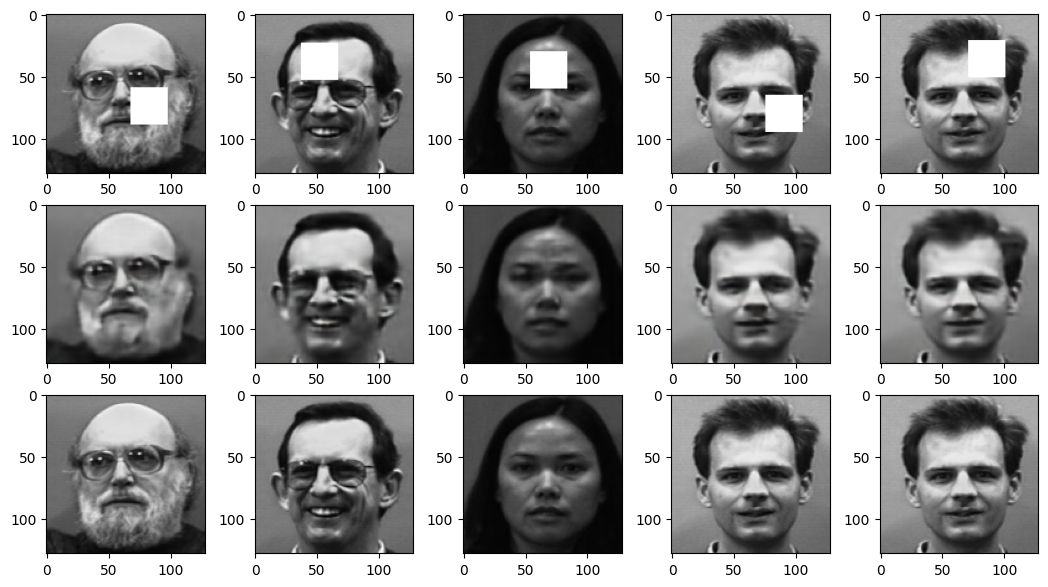

In [44]:
f,ax = plt.subplots(3,5,figsize=(13,7))
for i in range(5,10):
  img = X_test[i] # type float32
  ax[0,i-5].imshow(img)
for i in range(5,10):
  img = reconstructed_images[i] # type float32
  ax[1,i-5].imshow(img)
for i in range(5,10):
  img = y_test[i].astype(np.float32) # there are issues with plotting when the type is float64
  ax[2,i-5].imshow(img)


In [48]:
print("""
- The overcompelte autoencoder with convolutional layers is significatly better.
- Though the overall reconstruction is much better compared to the undercomplete CNN, the reconstructions of the occluded parts are still pixelated and don't blend in well.
- Has similar computation and memory requirements as the undercomplete autoencoder with convolutional layers.
""")


- The overcompelte autoencoder with convolutional layers is significatly better.
- Though the overall reconstruction is much better compared to the undercomplete CNN, the reconstructions of the occluded parts are still pixelated and don't blend in well.
- Has similar computation and memory requirements as the undercomplete autoencoder with convolutional layers.



# Image segmentation

Autoencoders can also be trained for image segmentation. Segmentation means separating specific objects in the image from the background. In practice, this usually comes down to coloring the relevant object in the image. Image segmentation finds its application in self-driving cars, video surveillance and medical imaging. The goal of this assignment is to segment lungs from X-ray images.


Pictures of the lungs can be found in the 'Lung_images' folder.

In this case, the labels are mask images indicating the exact location of the lungs in the image. These masks can be found in the 'Lung_masks' folder.


- Read the images and resize them to the same dimension. For example to 400x400 pixels. A lower resolution is also allowed if you notice that the system requirements are not sufficient. For this application you can convert the images to grayscale.

- Create a training set and test set. Put 20 images in the test set.

- Train a convolutional autoencoder on the training set. The output layer must have the same dimension as the mask images. The autoencoder is then trained to generate a mask based on a long scan that approximates the ground truth mask as closely as possible. However we'll need to use a custom loss function. In fact, cross-entropy based loss functions are not always the best option. In practice, the dice coefficient loss is often used. This loss function looks at the overlap between two data samples. In this case how much the mask generated by the autoencoder overlaps with the ground truth mask. You have to pass this dice loss as a custom loss fuction to the neural network.

```Python
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

```  

Test the auto encoder on the test set. Visualize the generated mask and compare with the actual mask. Try to improve the segmentation via hyperparameter tuning. Use the dice coefficient as a metric in addition to visual inspection.

 U-net is a widely used neural network for medical image segmentation. An implementation can be found here: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277. Implement, train and test this network. Also use the dice coefficient loss as the (custom) loss function. Discuss the results.
 



In [14]:
def get_metrics(model, x_test, y_test):
  mse_scores = []
  psnr_scores = []

  reconstructed_images = model.predict(x_test)
  for pred_img, real_img in zip(reconstructed_images, y_test):
    mse = calculate_mse(real_img, pred_img)
    psnr = calculate_psnr(real_img, pred_img)

    mse_scores.append(mse)
    psnr_scores.append(psnr)

  print(f"Average MSE: {np.mean(mse_scores)}")
  print(f"Average PSNR: {np.mean(psnr_scores)}")

  return reconstructed_images

In [16]:
# Image segmentation

import cv2, os, random

input_folders_lung = ('Lung_masks', 'Lung_images')

lung_images = []
lung_masks = []

for filename in os.listdir(input_folders_lung[0]):
  if filename.endswith(('.jpg', '.jpeg', '.png')):
    img_path = os.path.join(input_folders_lung[0], filename)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256,256))

    lung_masks.append(image)



for filename in os.listdir(input_folders_lung[1]):
  if filename.endswith(('.jpg', '.jpeg', '.png')):
    img_path = os.path.join(input_folders_lung[1], filename)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256,256))

    lung_images.append(image)


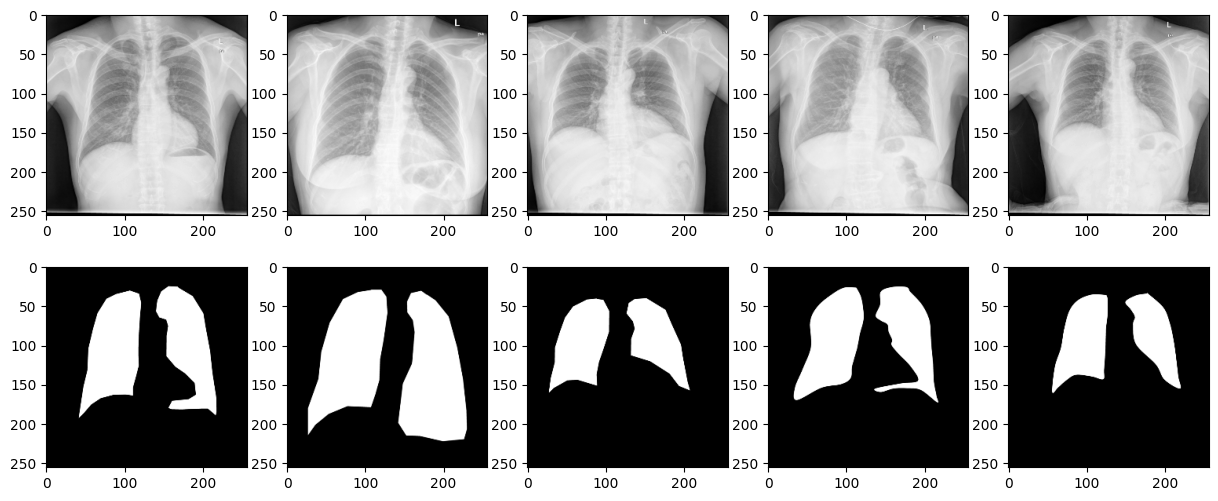

In [17]:
f,ax = plt.subplots(2,5, figsize=(15,6))
for i in range(5,10):
  ax[0,i-5].imshow(lung_images[i], cmap="gray")
for i in range(5,10):
  ax[1,i-5].imshow(lung_masks[i], cmap="gray")

In [18]:
data = list(zip(lung_images, lung_masks))
random.shuffle(data)

test_size = 20
test_data = data[:test_size]
train_data = data[test_size:]

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)

X_train = np.array(X_train).astype(np.float32)/255.0
y_train = np.array(y_train).astype(np.float32)/255.0
X_test = np.array(X_test).astype(np.float32)/255.0
y_test = np.array(y_test).astype(np.float32)/255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(684, 256, 256) (684, 256, 256)
(20, 256, 256) (20, 256, 256)


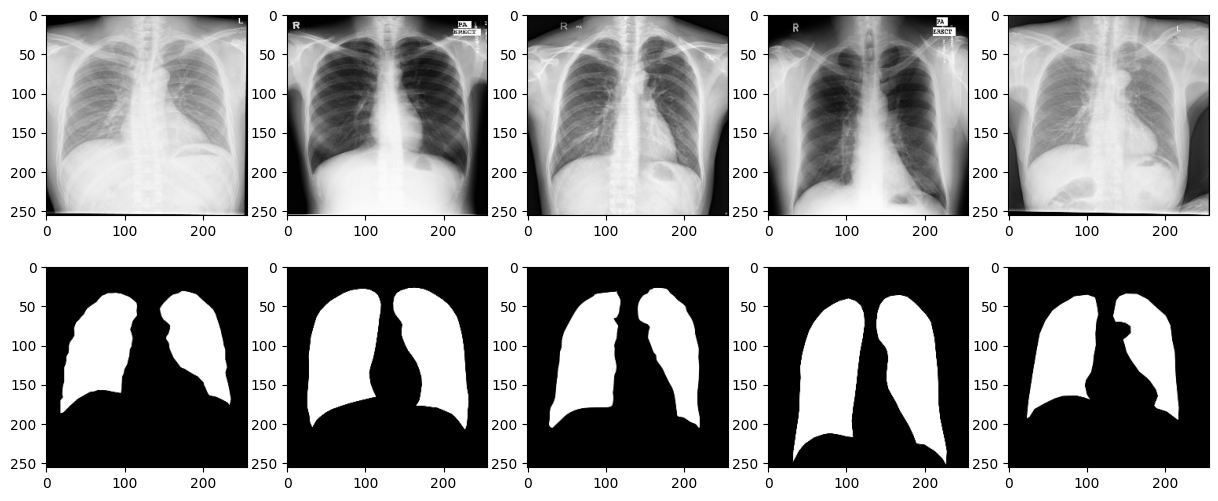

In [19]:
f,ax = plt.subplots(2,5, figsize=(15,6))
for i in range(5,10):
  ax[0,i-5].imshow(X_test[i], cmap="gray")
for i in range(5,10):
  ax[1,i-5].imshow(y_test[i], cmap="gray")

#### Undercomplete CNN

Undercomplete CNN with MSE Loss

In [20]:
# Encoder
input_img = Input(shape=(256, 256, 1))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoder = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Model
autoencoder = Model(input_img, decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

epochs = 130
batchsize = 20


autoencoder.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batchsize,
                shuffle=True,
                validation_split = 0.2)

Epoch 1/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 292ms/step - loss: 0.2048 - val_loss: 0.1562
Epoch 2/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1432 - val_loss: 0.1209
Epoch 3/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1000 - val_loss: 0.0772
Epoch 4/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0735 - val_loss: 0.0535
Epoch 5/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0527 - val_loss: 0.0466
Epoch 6/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0488 - val_loss: 0.0442
Epoch 7/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0435 - val_loss: 0.0488
Epoch 8/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0433 - val_loss: 0.0390
Epoch 9/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0414 - val_loss: 0.0381
Epoch 10/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0385 - val_loss: 0.0379
Epoch 11/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0379 - val_loss: 0.0423
Epoch 12/130
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Average MSE: 0.011606498621404171
Average PSNR: 67.66200113289436


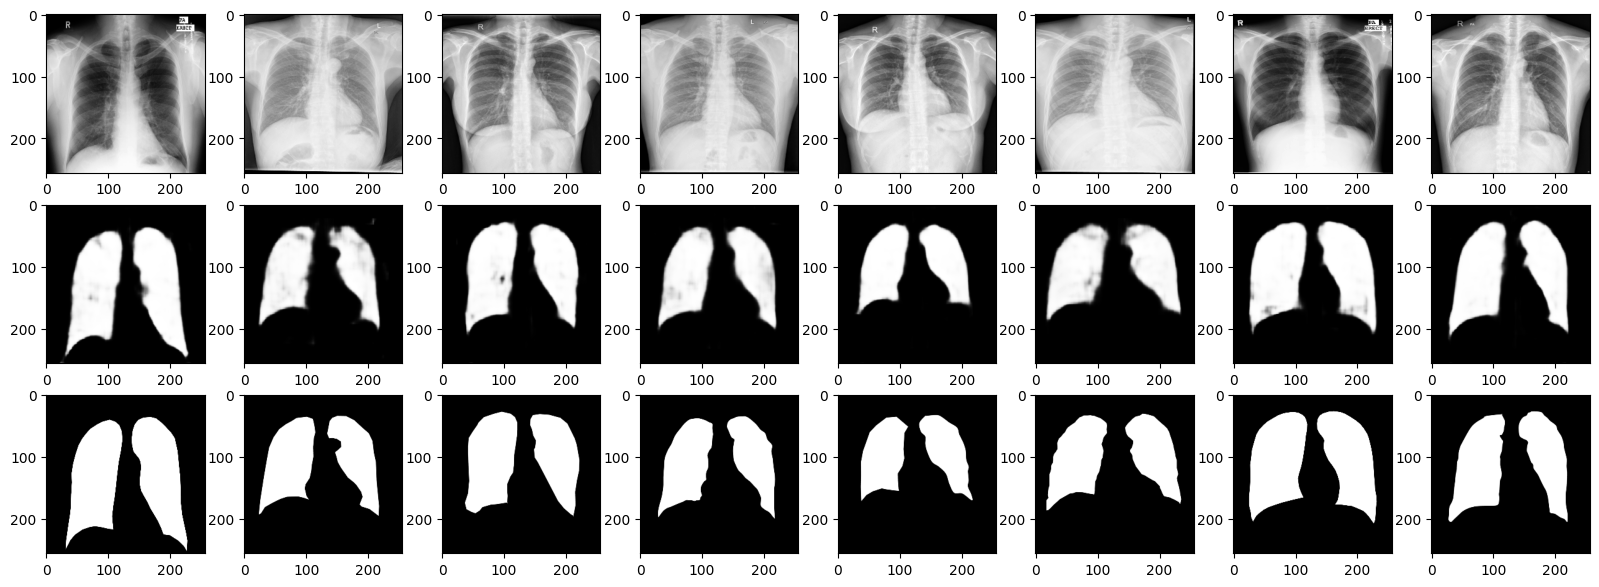

In [32]:
reconstructed_images = get_metrics(autoencoder, X_test, y_test)

f,ax = plt.subplots(3,8,figsize=(20,7))
for i in range(5,13):
  img = X_test[i] # type float32
  ax[0,i-8].imshow(img, cmap="gray")
for i in range(5,13):
  img = reconstructed_images[i] # type float32
  ax[1,i-8].imshow(img, cmap="gray")
for i in range(5,13):
  img = y_test[i].astype(np.float32) # there are issues with plotting when the type is float64
  ax[2,i-8].imshow(img, cmap="gray")


Undercomplete CNN with dice loss as the loss function

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [28]:
# Encoder
input_img = Input(shape=(256, 256, 1))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoder = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Model
autoencoder = Model(input_img, decoder)
autoencoder.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])


epochs = 150
batchsize = 10


autoencoder.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batchsize,
                shuffle=True,
                validation_split = 0.2)

Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 0.5692 - val_loss: 0.3485
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2886 - val_loss: 0.1991
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2043 - val_loss: 0.2178
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2084 - val_loss: 0.1845
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1807 - val_loss: 0.1555
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1642 - val_loss: 0.1464
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1601 - val_loss: 0.1834
Epoch 8/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1532 - val_loss: 0.1461
Epoch 9/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1424 - val_loss: 0.1426
Epoch 10/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1458 - val_loss: 0.1469
Epoch 11/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1318 - val_loss: 0.1319
Epoch 12/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Average MSE: 0.010685091838240623
Average PSNR: 68.18307274154691


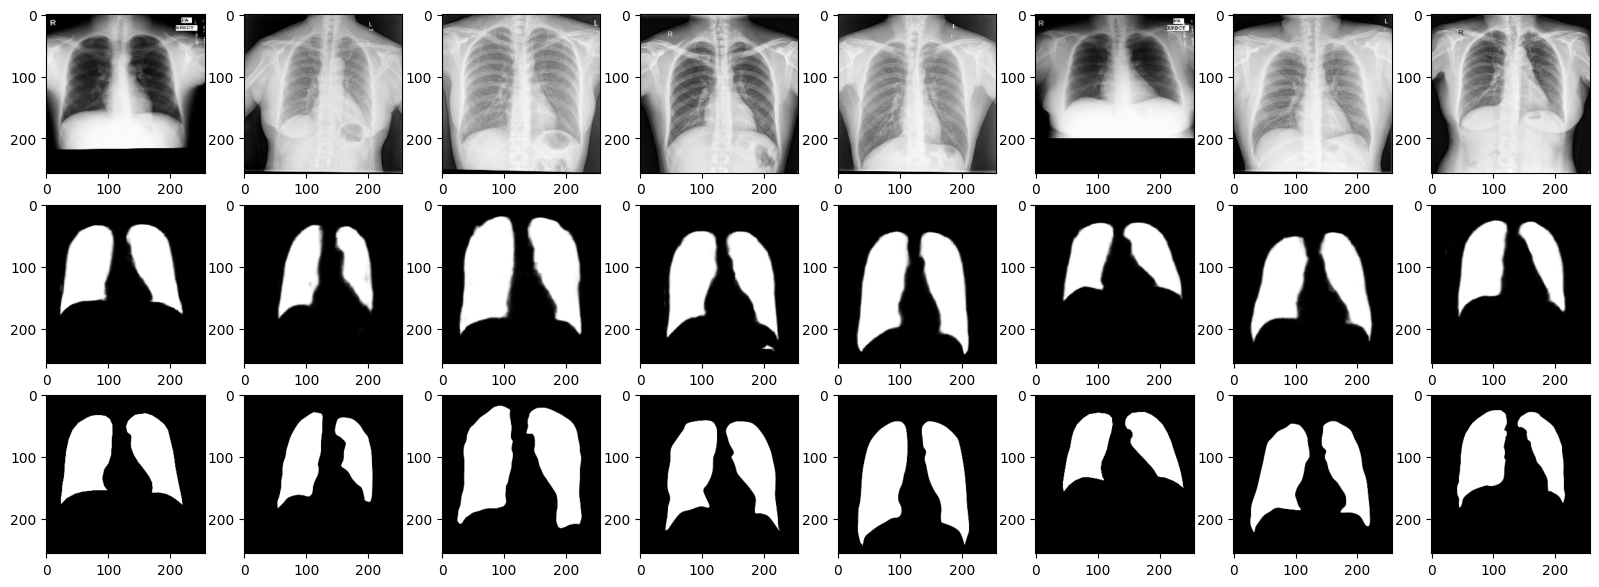

In [29]:
reconstructed_images = get_metrics(autoencoder, X_test, y_test)

f,ax = plt.subplots(3,8,figsize=(20,7))
for i in range(5,13):
  img = X_test[i] # type float32
  ax[0,i-8].imshow(img, cmap="gray")
for i in range(5,13):
  img = reconstructed_images[i] # type float32
  ax[1,i-8].imshow(img, cmap="gray")
for i in range(5,13):
  img = y_test[i].astype(np.float32) # there are issues with plotting when the type is float64
  ax[2,i-8].imshow(img, cmap="gray")



In [34]:
print("- Though both autoencoders good are generating the lung masks, the model with Dice Loss as its loss function significantly outperforms the other one.")
print("- Dice loss is better suited for segmentation tasks compared to MSE which is preferred for detecting pixel-wise differences. ")

- Though both autoencoders good are generating the lung masks, the model with Dice Loss as its loss function significantly outperforms the other one.
- Dice loss is better suited for segmentation tasks compared to MSE which is preferred for detecting pixel-wise differences. 


#### U-NET

In [48]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.MeanIoU(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [10]:
# Build U-Net model

inputs = Input((256, 256, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[tf.metrics.MeanIoU(2)])


epochs = 150
batchsize = 10


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=55, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
]


model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batchsize,
          shuffle=True,
          validation_split = 0.2,
          callbacks=callbacks)

Epoch 1/150


I0000 00:00:1731695307.709247  349537 service.cc:146] XLA service 0x7fbf68026cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731695307.709357  349537 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-11-15 19:28:27.846393: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-15 19:28:30.662794: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-15 19:28:46.802234: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward co

55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 351ms/step - loss: 0.5360 - mean_io_u: 0.4090 - val_loss: 0.1650 - val_mean_io_u: 0.8398 - learning_rate: 0.0010
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1605 - mean_io_u: 0.7951 - val_loss: 0.1217 - val_mean_io_u: 0.7147 - learning_rate: 0.0010
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0976 - mean_io_u: 0.5801 - val_loss: 0.0803 - val_mean_io_u: 0.4154 - learning_rate: 0.0010
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0817 - mean_io_u: 0.4389 - val_loss: 0.0788 - val_mean_io_u: 0.4200 - learning_rate: 0.0010
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0737 - mean_io_u: 0.3997 - val_loss: 0.0866 - val_mean_io_u: 0.3747 - learning_rate: 0.0010
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0690 - mean_io_u: 0.3977 - val_loss: 0.0679 - val_mean_io_u: 0.3750 - learning_rate: 0.0010
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0621 - mean_io_u: 0.3821

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Average MSE: 0.013722633942961693
Average PSNR: 67.4379244541827


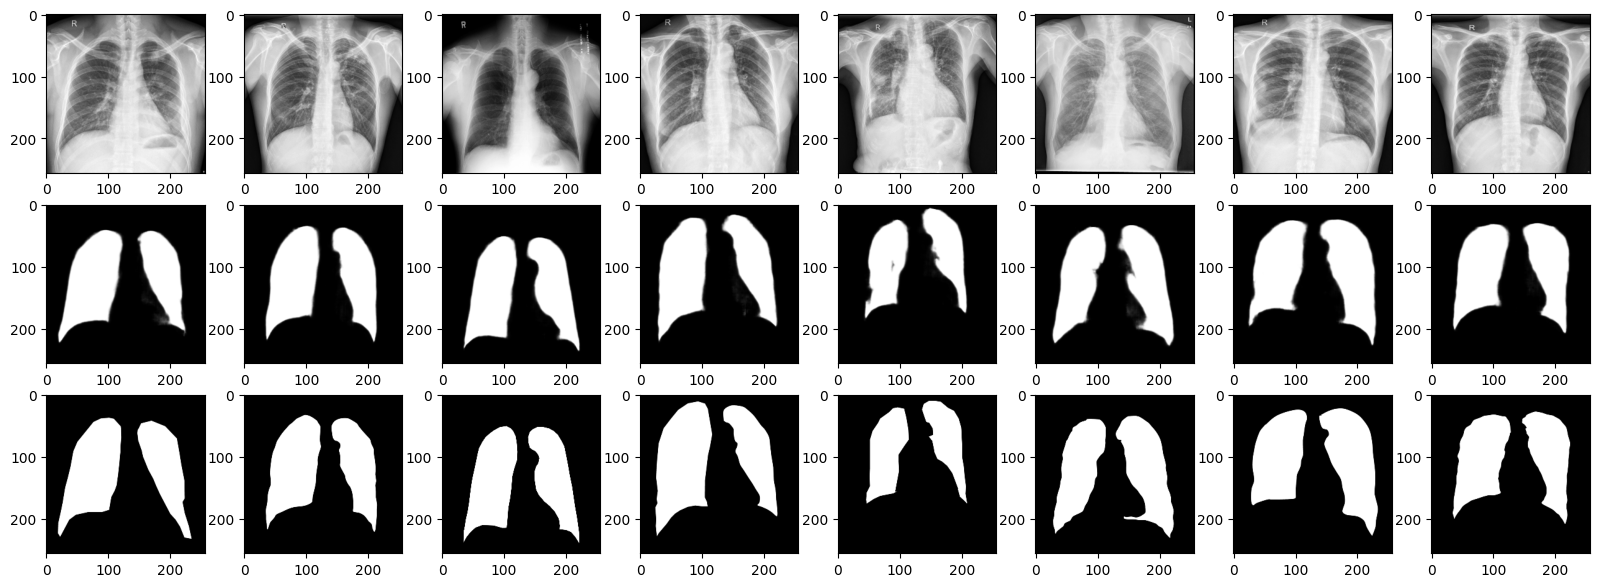

In [12]:
reconstructed_images = get_metrics(model, X_test, y_test)

f,ax = plt.subplots(3,8,figsize=(20,7))
for i in range(5,13):
  img = X_test[i] # type float32
  ax[0,i-8].imshow(img, cmap="gray")
for i in range(5,13):
  img = reconstructed_images[i] # type float32
  ax[1,i-8].imshow(img, cmap="gray")
for i in range(5,13):
  img = y_test[i].astype(np.float32) # there are issues with plotting when the type is float64
  ax[2,i-8].imshow(img, cmap="gray")



In [41]:
print("""
- The edges are noticeably sharper and more defined in the U-net generated masks compared to those of the basic undercomplete autoencoder.
- The U-net model requires more computational power compared to the simple undercomplete autoencoder.
- Both the undercomplete autoencoder and the U-Net model demonstrate satisfactory performance.""")



- The edges are noticeably sharper and more defined in the U-net generated masks compared to those of the basic undercomplete autoencoder.
- The U-net model requires more computational power compared to the simple undercomplete autoencoder.
- Both the undercomplete autoencoder and the U-Net model demonstrate satisfactory performance.
